# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
import time
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

from preprocessing import load_wisconsin_prepr

# Interpretability measures
from interpretability import PDP, generate_counterfactuals, inverse_transform
from anchor import anchor_tabular
import lime
import lime.lime_tabular

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [ ]:
X, y, feature_names, categorical = load_wisconsin_prepr()
seed = 3011

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X.shape)

(569, 30)


# Training models

## Sci-kit learn models

In [ ]:
model_names = [
    "k-nearest neighbors", 
    "decision tree classifier",
    "support vector classifier",
    ]

parameters = {
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')}, # 'n_neighbors': np.arange(1, 364)
    "decision tree classifier": {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 20)}, # 'min_samples_split': np.arange(2, 364)
    "support vector classifier": {'C': np.geomspace(0.01, 100, 41)}
    }

models_init = {
    "k-nearest neighbors": KNeighborsClassifier(),
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "support vector classifier": SVC(kernel="linear", probability=True)
    }

models = dict()
train_times = dict()

for model_name in model_names:
    start = time.time()
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    end = time.time()
    
    models[model_name] = clf.best_estimator_
    train_times[model_name] = (end - start)

## Neural network

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train_nn.shape[1]

set_seed(seed)

start = time.time()
model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 1816
history = model.fit(X_train_nn, y_train_nn, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val_nn, y_val_nn))
end = time.time()

models["neural network"] = model
train_times["neural network"] = (end - start)

6/6 [==============================] - 0s 12ms/step - loss: 0.0020 - binary_accuracy: 1.0000 - val_loss: 1.1643e-05 - val_binary_accuracy: 1.0000
Epoch 1318/1816
6/6 [==============================] - 0s 11ms/step - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 1.1604e-05 - val_binary_accuracy: 1.0000
Epoch 1319/1816
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 1.1574e-05 - val_binary_accuracy: 1.0000
Epoch 1320/1816
6/6 [==============================] - 0s 11ms/step - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 1.1527e-05 - val_binary_accuracy: 1.0000
Epoch 1321/1816
6/6 [==============================] - 0s 12ms/step - loss: 0.0019 - binary_accuracy: 1.0000 - val_loss: 1.1469e-05 - val_binary_accuracy: 1.0000
Epoch 1322/1816
6/6 [==============================] - 0s 14ms/step - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 1.1293e-05 - val_binary_accuracy: 1.0000
Epoch 1323/1816
6/6 [=======================

## Errors and times

In [ ]:
for name, model_time in train_times.items():
    print(f"Model {name} took {model_time} seconds to train")

Model k-nearest neighbors took 3.1479954719543457 seconds to train
Model decision tree classifier took 1.2128045558929443 seconds to train
Model support vector classifier took 2.342186212539673 seconds to train
Model neural network took 84.40333700180054 seconds to train


In [ ]:
for model_name in models.keys():
    print_errors(models[model_name], model_name, X_test, y_test)

Balanced accuracy (k-nearest neighbors) = 0.9523809523809523
F1 = 0.972972972972973
Accuracy = 0.9649122807017544
	class 0: 0.9047619047619048
	class 1: 1.0
Balanced accuracy (decision tree classifier) = 0.9295634920634921
F1 = 0.943661971830986
Accuracy = 0.9298245614035088
	class 0: 0.9285714285714286
	class 1: 0.9305555555555556
Balanced accuracy (support vector classifier) = 0.9404761904761905
F1 = 0.9664429530201343
Accuracy = 0.956140350877193
	class 0: 0.8809523809523809
	class 1: 1.0
Balanced accuracy (neural network) = 0.9761904761904762
F1 = 0.9863013698630138
Accuracy = 0.9824561403508771
	class 0: 0.9523809523809523
	class 1: 1.0


In [ ]:
inference_times = dict()

X_copy = np.tile(X_test[:50], (20000, 1))

for model_name, model in models.items():
    start = time.time()
    y_pred = model.predict(X_copy)
    end = time.time()
    inference_times[model_name] = (end - start)

for model_name, inference_time in inference_times.items():
    print(f"Model {model_name} took {inference_time} seconds to make 1 000 000 predictions")

Model k-nearest neighbors took 12.552847146987915 seconds to make 1 000 000 predictions
Model decision tree classifier took 0.10207462310791016 seconds to make 1 000 000 predictions
Model support vector classifier took 2.099548101425171 seconds to make 1 000 000 predictions
Model neural network took 23.891397714614868 seconds to make 1 000 000 predictions


# Intrinsic interpretability

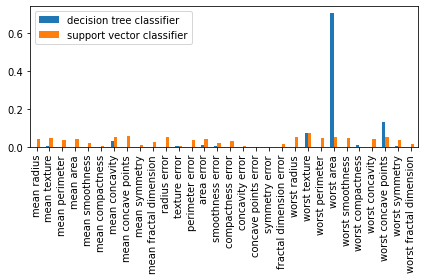

In [ ]:
dtr_feat_imps = models["decision tree classifier"].feature_importances_

svc_coefs = models["support vector classifier"].coef_[0]
svc_feat_imps = np.abs(svc_coefs) / np.sum(np.abs(svc_coefs))

intr_feat_imps = pd.DataFrame({"decision tree classifier": dtr_feat_imps, "support vector classifier": svc_feat_imps}, index=feature_names)
intr_feat_imps.plot.bar()

# plt.show()
plt.tight_layout()
plt.savefig(f"Figures/wisconsin/intrinsic_feature_importance_wisconsin.png", dpi=300)
plt.show()
plt.close()

# Partial dependence plots

In [ ]:
def inverse_transform(X, feat_idx, scaler):
    return X * np.sqrt(scaler.var_[feat_idx]) + scaler.mean_[feat_idx]

In [ ]:
for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(len(feature_names)):
        feat_values, PDP_values = PDP("classification", i, feature_names[i], model, X_test, y_test, categorical=categorical[i])

        # Make a line plot if feature is not categorical and a bar plot if it is categorical
        plt.xlabel(feature_names[i])
        plt.ylabel("Average prediction")

        original_feat_values = inverse_transform(feat_values, i, scaler)

        if not categorical[i]:
            plt.plot(original_feat_values, PDP_values)
        else:
            diff = max(PDP_values) - min(PDP_values)
            if diff != 0.0:
                plt.ylim(max(min(PDP_values) - 0.2 * diff, 0.0), max(PDP_values) + 0.2 * diff)
            else:
                plt.ylim(min(PDP_values) - 0.001, max(PDP_values) + 0.001)
            
            tick_label = original_feat_values
            plt.bar(original_feat_values, PDP_values, width=(original_feat_values[1]-original_feat_values[0]) * 0.9, tick_label=tick_label)

        # plt.show()
        plt.savefig(f"Figures/wisconsin/PDP_wisconsin_{model_name}_{i}.png", dpi=300)
        plt.close()

k-nearest neighbors
decision tree classifier
support vector classifier
neural network


# SHAP

## Instance-based interpretability

In [ ]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, X.shape[0])
      return classify(np.array(y_pred))

    explainers[model_name] = shap.KernelExplainer(nn_predict, shap.kmeans(X_train, 250)) # shap.sample(X_train, 200))
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 250)) # shap.sample(X_train, 200))

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


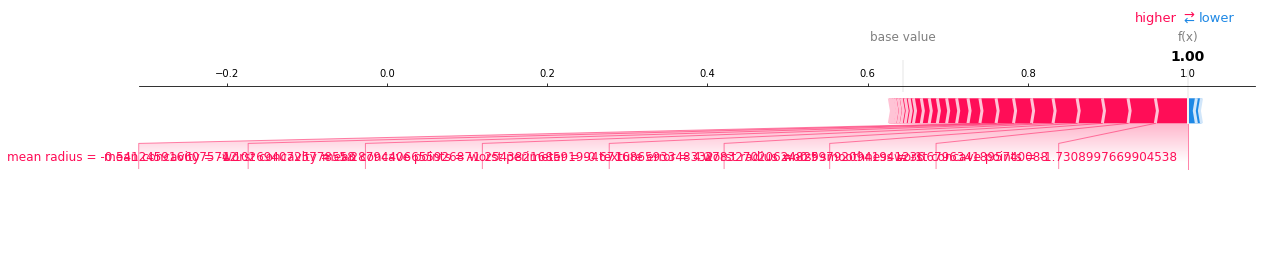

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


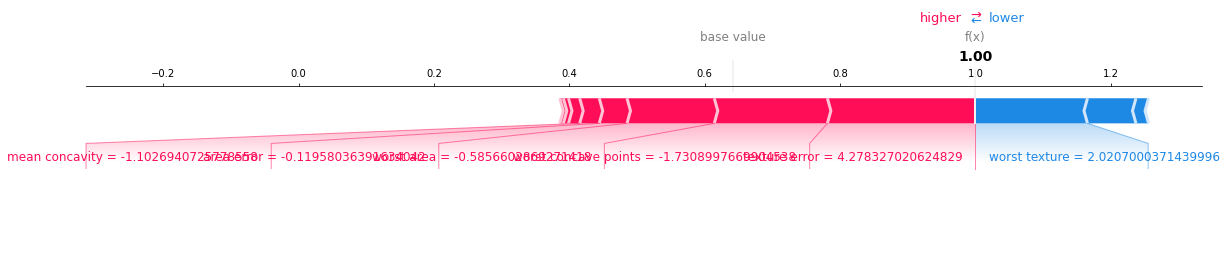

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


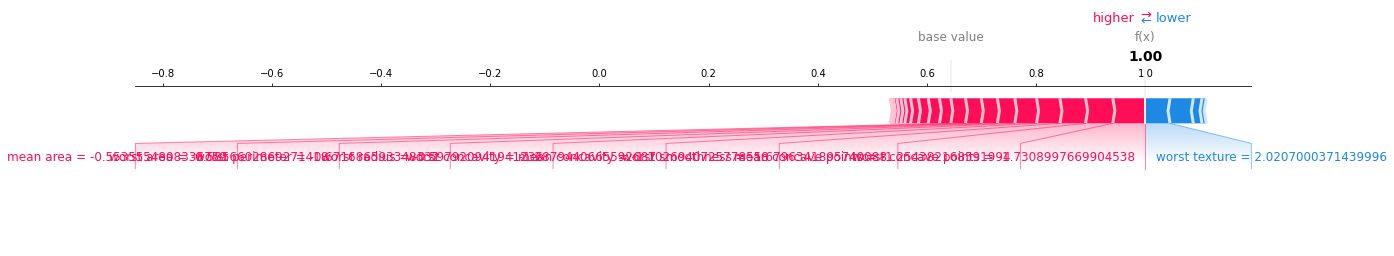

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


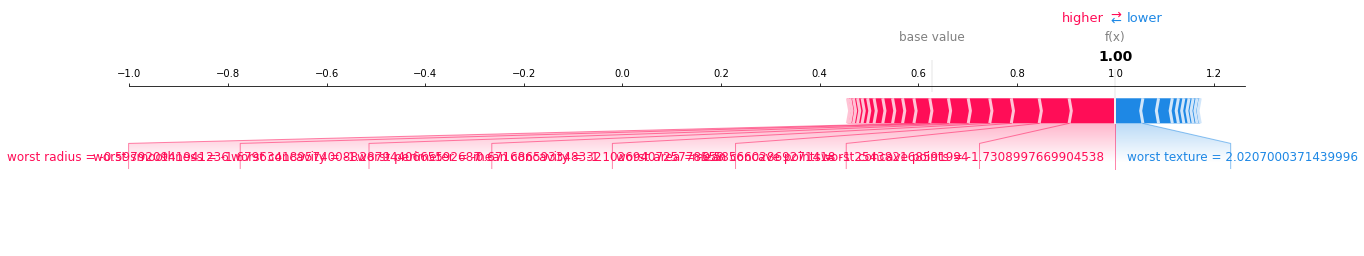

In [ ]:
idx = 4
shap_instance_times = dict()

for model_name in models.keys():
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    start = time.time()
    explainer = explainers[model_name]
    shap_instance = explainer.shap_values(X_test_df.iloc[idx])
    end = time.time()

    shap_instance_times[model_name] = (end - start)

    """
    # PLOT SHAP VALUES IN NORMAL WAY
    shap_instance = pd.DataFrame(shap_instance, index=feature_names)
    shap_instance.plot.bar(legend=None)
    plt.tight_layout()
    plt.savefig(f"Figures/wisconsin/SHAP_instance_wisconsin_{model_name}_{idx}.png", dpi=300)
    plt.close()
    """

    # shap.initjs()
    shap.force_plot(explainer.expected_value, shap_instance, X_test_df.iloc[idx], matplotlib=True)
    plt.show()

In [ ]:
for model_name, model_time in shap_instance_times.items():
    print(f"Model {model_name} took {model_time} seconds to explain an instance using SHAP")

Model k-nearest neighbors took 9.201044797897339 seconds to explain an instance using SHAP
Model decision tree classifier took 1.968376636505127 seconds to explain an instance using SHAP
Model support vector classifier took 3.042185068130493 seconds to explain an instance using SHAP
Model neural network took 9.25155520439148 seconds to explain an instance using SHAP


## Global interpretation

    shap_global_times = dict()
    # X_test_df = pd.DataFrame(X_test, columns=feature_names)

    for model_name in models.keys():
        start = time.time()
        print(model_name)
        explainer = explainers[model_name]

        shap_values = explainer.shap_values(shap.sample(X_test, 50, random_state=seed))
        np.savetxt(f"Output/wisconsin/shap_values_wisconsin_{model_name}.txt", shap_values)
        end = time.time()

        shap_global_times[model_name] = (end - start)

    for name, model_time in shap_global_times.items():
        print(f"Model {name} took {model_time} seconds to explain using SHAP")

In [ ]:
shap_values_all = dict()

for model_name in models.keys():
    shap_values_all[model_name] = np.loadtxt(f"Output/wisconsin/shap_values_wisconsin_{model_name}.txt")

In [ ]:
shap_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shap_feat_imps.insert(0, model_name, feat_imps)

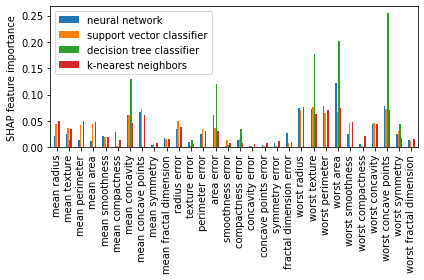

In [ ]:
shap_feat_imps.plot.bar()
plt.ylabel("SHAP feature importance")
plt.tight_layout()
plt.savefig("Figures/wisconsin/SHAP_feature_importance_wisconsin.png", dpi=300)
plt.show()
plt.close()

# Counterfactuals

In [ ]:
instance_idx = 3
counterfactual_times = dict()

total_time = 500

for model_name in models.keys():
    print(model_name)
    
    instance = X_test[instance_idx]
    model = models[model_name]

    start = time.time()
    counterfactuals, counterfactual_losses = generate_counterfactuals("classification", instance, X_train, model, categorical, seed, total_time=total_time)
    end = time.time()

    counterfactual_times[model_name] = (end - start)

    np.savetxt(f"Output/wisconsin/counterfactuals_wisconsin_{model_name}_instance{instance_idx}.txt", counterfactuals)
    np.savetxt(f"Output/wisconsin/counterfactual_losses_wisconsin_{model_name}_instance{instance_idx}.txt", counterfactual_losses)

k-nearest neighbors
Original prediction: 1
100%|██████████| 500/500 [00:30<00:00, 16.17it/s]
Counterfactual_losses: [13.80545196 14.42555065 15.45449278 15.61082419 15.69345746 15.83078739
 15.90308202 15.92402336 16.29997083 16.88190813]
decision tree classifier
Original prediction: 1
100%|██████████| 500/500 [00:00<00:00, 551.34it/s]
Counterfactual_losses: [1.57362822 1.85132327 2.18021981 2.25921293 2.32255723 3.02506961
 3.44611297 4.22928455 4.46726858 4.51600786]
support vector classifier
Original prediction: 1
100%|██████████| 500/500 [00:01<00:00, 468.12it/s]
Counterfactual_losses: [12.31100729 13.0136666  13.07585192 13.17326586 13.34420961 13.46613313
 13.58646253 13.60729921 13.77986293 13.8261975 ]
neural network
Original prediction: 1
100%|██████████| 500/500 [03:34<00:00,  2.33it/s]Counterfactual_losses: [5.128075   5.1851478  6.40578911 6.71500083 7.09374488 7.16857671
 7.41424574 7.78563046 8.33643839 8.35209365]



In [ ]:
for model_name, model_time in counterfactual_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate counterfactuals")

Model k-nearest neighbors took 30.946890830993652 seconds to generate counterfactuals
Model decision tree classifier took 0.9095337390899658 seconds to generate counterfactuals
Model support vector classifier took 1.0709710121154785 seconds to generate counterfactuals
Model neural network took 214.36508870124817 seconds to generate counterfactuals


# Anchors

In [ ]:
cat_dict = {}
class_names = ['Malignant', 'Benign']
anch_exp = anchor_tabular.AnchorTabularExplainer(
    class_names,
    ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
    X_train,
    cat_dict
)

idx = 10

tmp = X_test[idx].reshape(1, -1)

np.random.seed(seed)

anchor_times = dict()

for name in models.keys():
    t =  anch_exp.class_names[int(
        models[name].predict(tmp))]

    start = time.time()

    if name == "neural network":
        def nn_predict(X):
            y_pred = models["neural network"].predict(X)
            y_pred = np.reshape(y_pred, y_pred.shape[0])
            return classify(np.array(y_pred))

        expl = anch_exp.explain_instance(
            X_test[idx],
            nn_predict, threshold=0.6) # Change threshold a bit for more interesting anchors

    else:
        expl = anch_exp.explain_instance(
            X_test[idx],
            models[name].predict, threshold=0.6) # Change threshold a bit for more interesting anchors
    
    end = time.time()

    anchor_times[name] = (end - start)

    print(f"Anchor based on {name} gives: ")
    print('Anchor: %s' % (' AND '.join(expl.names())))
    print('Precision: %.2f' % expl.precision())
    print('Coverage: %.2f' % expl.coverage())

Anchor based on k-nearest neighbors gives: 
Anchor: worst area > -0.33 AND worst perimeter > 0.60
Precision: 1.00
Coverage: 0.25
Anchor based on decision tree classifier gives: 
Anchor: area error > 0.12
Precision: 0.66
Coverage: 0.25
Anchor based on support vector classifier gives: 
Anchor: mean area > -0.29 AND worst perimeter > 0.60
Precision: 1.00
Coverage: 0.24
Anchor based on neural network gives: 
Anchor: worst area > 0.49 AND worst perimeter > 0.60
Precision: 1.00
Coverage: 0.25


In [ ]:
for model_name, model_time in anchor_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate anchor rules")

Model k-nearest neighbors took 27.975117683410645 seconds to generate anchor rules
Model decision tree classifier took 2.079793930053711 seconds to generate anchor rules
Model support vector classifier took 6.878538370132446 seconds to generate anchor rules
Model neural network took 15.488633155822754 seconds to generate anchor rules


# LIME

## Instance-based interpretability

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
    feature_names=['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], 
    class_names=['Malignant', 'Benign'],
    categorical_features=[], 
    mode='classification')

In [ ]:
np.random.seed(20)
idx = 1
lime_times = dict()

for name in models.keys():
    print(f"Lime explanation for {name}")
    start = time.time()
    if name == "neural network":
        def nn_predict_proba(X):
            y_pred = models[name].predict(X)
            y_prob = np.tile(y_pred, (1, 2))
            y_prob[:,0] = 1.0 - y_prob[:,-1]
            return y_prob
        
        exp = explainer.explain_instance(X_test[idx], nn_predict_proba, num_features=14) 
    else: 
        exp = explainer.explain_instance(X_test[idx], models[name].predict_proba, num_features=14) # Change num_featurese for more or less explainations
    
    exp.show_in_notebook(show_table=True)
    end = time.time()
    lime_times[name] = (end - start)
print(y_test[idx])

In [ ]:
for model_name, model_time in lime_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate an explanation using LIME")

Model k-nearest neighbors took 24.869879007339478 seconds to generate an explanation using LIME
Model decision tree classifier took 23.093438863754272 seconds to generate an explanation using LIME
Model support vector classifier took 22.976084232330322 seconds to generate an explanation using LIME
Model neural network took 23.599592208862305 seconds to generate an explanation using LIME


## Global interpretation

    lime_global_times = dict()
    np.random.seed(seed)

    for model_name in models.keys():
        start = time.time()
        print(model_name)
        lime_values = np.zeros((50, len(feature_names)))

        for idx, instance in enumerate(shap.sample(X_test, 50, random_state=seed)):
        
            if model_name == "neural network":

                def nn_predict_proba(X):
                    y_pred = models[model_name].predict(X)
                    y_prob = np.tile(y_pred, (1, 2))
                    y_prob[:,0] = 1.0 - y_prob[:,-1]
                    return y_prob

                exp = explainer.explain_instance(instance, nn_predict_proba, num_features=14)

            else: 
                exp = explainer.explain_instance(instance, models[model_name].predict_proba, num_features=14)

            exp_dict = exp.as_map()

            for feat_idx, lime_value in exp_dict[1]:
                lime_values[idx, feat_idx] = lime_value

        end = time.time()
        lime_global_times[model_name] = (end - start)
        np.savetxt(f"Output/wisconsin/lime_values_wisconsin_{model_name}.txt", lime_values)
        print("---------------------------------------------------------------")

    for name, model_time in lime_global_times.items():
        print(f"Model {name} took {model_time} seconds to explain using LIME")

In [ ]:
lime_values_all = dict()

for model_name in models.keys():
    lime_values_all[model_name] = np.loadtxt(f"Output/wisconsin/lime_values_wisconsin_{model_name}.txt")

In [ ]:
lime_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  lime_values = lime_values_all[model_name]
  feat_imps = np.mean(np.abs(lime_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  lime_feat_imps.insert(0, model_name, feat_imps)

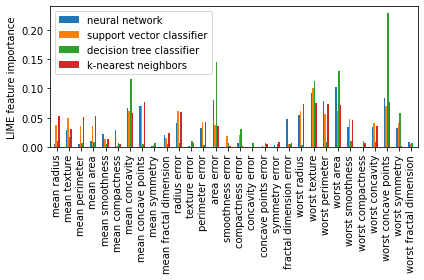

In [ ]:
lime_feat_imps.plot.bar()
plt.ylabel("LIME feature importance")
plt.tight_layout()
plt.savefig("Figures/wisconsin/LIME_feature_importance_wisconsin.png", dpi=300)
plt.show()
plt.close()

# Comparing feature importances

    intr_mapper = dict()
    shap_mapper = dict()

    for model_name in models.keys():
        intr_mapper[model_name] = model_name + " (intrinsic)"
        shap_mapper[model_name] = model_name + " (SHAP)"

    intr_feat_imps.rename(columns=intr_mapper, errors="ignore")
    shap_feat_imps.rename(columns=shap_mapper)

    all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shap_feat_imps.rename(columns=shap_mapper)], axis=1)

In [ ]:
intr_mapper = {
    "decision tree classifier": "dtr (intr)", 
    "support vector classifier": "svc (intr)", 
    # "k-nearest neighbors": "knn (intr)", 
    # "neural network": "nn (intr)",
    }

shap_mapper = {
    "decision tree classifier": "dtr (SHAP)", 
    "support vector classifier": "svc (SHAP)", 
    "k-nearest neighbors": "knn (SHAP)", 
    "neural network": "nn (SHAP)",
    }

lime_mapper = {
    "decision tree classifier": "dtr (LIME)", 
    "support vector classifier": "svc (LIME)", 
    "k-nearest neighbors": "knn (LIME)", 
    "neural network": "nn (LIME)",
    }

all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shap_feat_imps.rename(columns=shap_mapper), lime_feat_imps.rename(columns=lime_mapper)], axis=1)

In [ ]:
all_feat_imps_columns = all_feat_imps.columns
jaccard_sim = pd.DataFrame(np.zeros((len(all_feat_imps_columns), len(all_feat_imps_columns))), index=all_feat_imps_columns, columns=all_feat_imps_columns)
jaccard_sims = list()

for k in range(1, len(feature_names) + 1):
    for column_name_1 in all_feat_imps_columns:
        for column_name_2 in all_feat_imps_columns:
            feat_imps_1 = np.array(all_feat_imps[column_name_1])
            feat_imps_2 = np.array(all_feat_imps[column_name_2])

            top_features_1 = feature_names[np.argsort(feat_imps_1)][::-1][:k]
            top_features_2 = feature_names[np.argsort(feat_imps_2)][::-1][:k]

            union = len(top_features_1)
            intersec = 0

            for feature in top_features_1:
                if feature in top_features_2:
                    intersec += 1
                else: 
                    union += 1

            jaccard_sim[column_name_1][column_name_2] = intersec / union

    f, ax = plt.subplots(figsize=(6, 6), dpi=300)
    sns.heatmap(jaccard_sim, vmin=0.0, vmax=1.0, annot=True, square=True)
    plt.tight_layout()
    plt.savefig(f"Figures/wisconsin/jaccard_wisconsin_top_{k}.png")
    plt.close()

    jaccard_sims.append(jaccard_sim.copy())

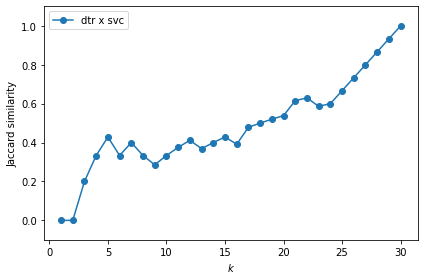

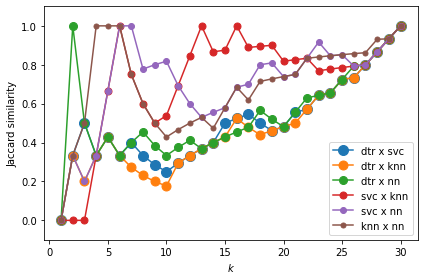

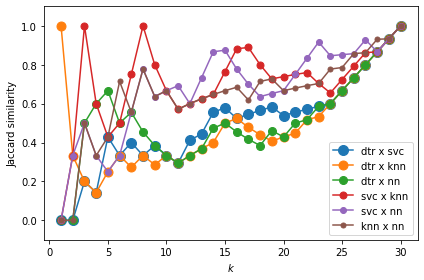

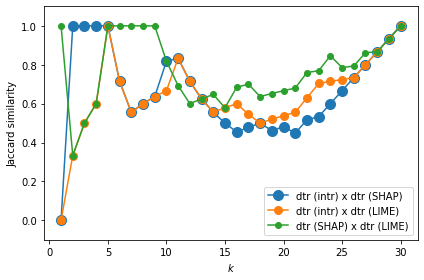

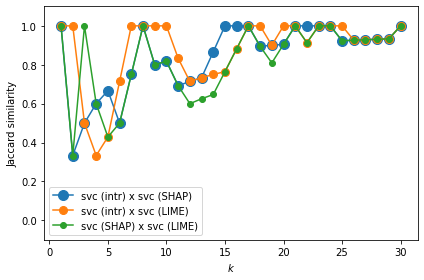

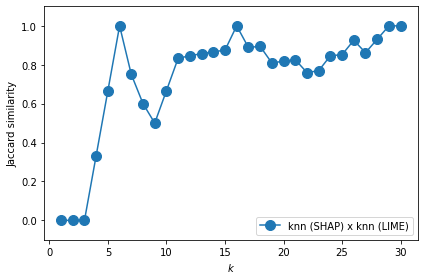

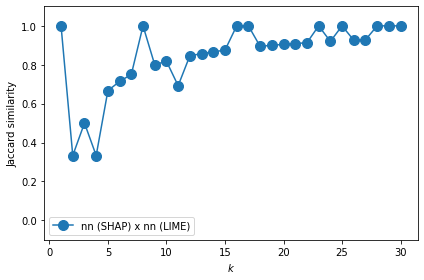

In [ ]:
# Compare intrinsic values
compairs = [("dtr (intr)", "svc (intr)")]

for pair in compairs:
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o")

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_intr_models.png", dpi=300)
plt.show()
plt.close()

# Compare SHAP values
compairs = [
    ("dtr (SHAP)", "svc (SHAP)"),
    ("dtr (SHAP)", "knn (SHAP)"),
    ("dtr (SHAP)", "nn (SHAP)"),
    ("svc (SHAP)", "knn (SHAP)"),
    ("svc (SHAP)", "nn (SHAP)"),
    ("knn (SHAP)", "nn (SHAP)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o", markersize=10-1.0*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_SHAP_models.png", dpi=300)
plt.show()
plt.close()

# Compare LIME models
compairs = [
    ("dtr (LIME)", "svc (LIME)"),
    ("dtr (LIME)", "knn (LIME)"),
    ("dtr (LIME)", "nn (LIME)"),
    ("svc (LIME)", "knn (LIME)"),
    ("svc (LIME)", "nn (LIME)"),
    ("knn (LIME)", "nn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o", markersize=10-1.0*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_LIME_models.png", dpi=300)
plt.show()
plt.close()

# Compare decision tree interpretability
compairs = [
    ("dtr (intr)", "dtr (SHAP)"),
    ("dtr (intr)", "dtr (LIME)"),
    ("dtr (SHAP)", "dtr (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_decision_tree_classifier.png", dpi=300)
plt.show()
plt.close()

# Compare support vector interpretability
compairs = [
    ("svc (intr)", "svc (SHAP)"),
    ("svc (intr)", "svc (LIME)"),
    ("svc (SHAP)", "svc (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_support_vector_classifier.png", dpi=300)
plt.show()
plt.close()

# Compare kNN interpretability
compairs = [
    ("knn (SHAP)", "knn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_k_nearest_neighbors_classifier.png", dpi=300)
plt.show()
plt.close()

# Compare neural network interpretability
compairs = [
    ("nn (SHAP)", "nn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/wisconsin/jaccard_neural_network_classifier.png", dpi=300)
plt.show()
plt.close()

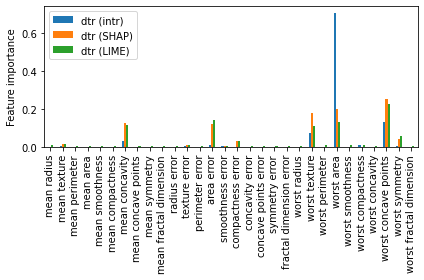

In [ ]:
all_feat_imps[["dtr (intr)", "dtr (SHAP)", "dtr (LIME)"]].plot.bar()
plt.ylabel("Feature importance")
plt.tight_layout()
plt.savefig("Figures/loan/comp_dtr_feature_importance_loan.png", dpi=300)
plt.show()
plt.close()

# Prutsen

In [ ]:
def postproces_data(X, scaler):
    return X * np.sqrt(scaler.var_) + scaler.mean_

In [ ]:
# Beste aantal epochs zoeken

for key in history.history.keys():
    plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
plt.legend()
plt.show()

print(np.argmin(history.history['val_loss']))
print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>